# **SMILearn**
*A feature engineering module for deep learning models, based on a  SMILES representation of chemical compounds.*  
This notebook is an example study showing how to construct and customize TensorFlow pipelines using SMILearn objects.

## 1. Introduction

### 1.1. Aim of the study
This study aims to find the simplest possible feature matrices, generated from SMILES strings, as inputs for neural networks, without significant loss of the accuracy compared to more complex reference matrices.

### 1.2. SMILES notation
The structure of a chemical compound can be described in a linear form (string) following the rules of the simplified molecular-input line-entry system (SMILES).<sup>[1][2]</sup><br/><br/>
Brief description:
* Atoms are represented by their symbols in square brackets which can be omitted in case of the most common symbols (`B`, `C`, `N`, `O`, `F`, `P`, `S`, `Cl`, `Br`, `I`) when they have default properties. Lower case symbols describe atoms in aromatic rings. By default, hydrogen atoms are not shown explicitly. Their number is calculated from the difference in the number of implicit and explicit bonds.
* Bonds are specified by the symbols:  
`.` - ionic,  
`-` - single,  
`/`, `\` - single up and down respectively (next to a double bond),  
`:` - aromatic (between single and double),  
`=` - double,  
`#` - triple.  
By default, single and aromatic bonds are not shown explicitly.
* Branches are represented by the parentheses.
* Ring connections are specified by the pairs of digit indices.
* Additional symbols inside square brackets describe charge (`+`, `-`) or chirality (`@`, `@@`)
<br/><br/>

**Examples**

Compound name | Condensed structural formula | SMILES | Comments
--- | --- | --- | ---
Ethanol | CH<sub>3</sub>CH<sub>2</sub>OH | `CCO` | All atoms have default properties (neutral charge, no chirality, typical valence, etc.),<br/>and are not written in square brackets.<br/>Hydrogen atoms and single bonds can be implict.
Calcium hypochlorite | Ca(ClO)<sub>2</sub> | `[Ca+2].[O-]Cl.[O-]Cl` | Atoms with charges are written in square brackets.<br/>Ionic bonds must be shown but single bonds not.
Silicon dioxide | SiO<sub>2</sub> | `O=[Si]=O` | Silicon is not present in the most common symbols set and must be written in square brackets.<br/>Double bonds must be explicit.
L-Lactonitrile | CH<sub>3</sub>CH(OH)CN | `C[C@@H](O)C#N` | Oxygen atom is inside a branch.<br/>Stereogenic carbon atom is written in square brackets with chiral tag.<br/>Single bonds can be implicit, but triple bond not.
*trans*-Cinnamic acid | C<sub>6</sub>H<sub>6</sub>CHCHCOOH | `c1ccccc1/C=C/C(=O)O` | Ring connection is denoted by a pair of digits.<br/>Carbon atoms in the aromatic ring are written in lower case.<br/>Double, single up and single down bonds must be shown but aromatic bonds not.
<br/><br/>

**SMILES generation algorithm**  
<sup>*Source*: https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system</sup>  
![alt text][fig1]

[fig1]: https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/SMILES.png/300px-SMILES.png 'SMILES generation algorithm'

## 2. Materials and methods

### 2.1. Prerequisites

#### 2.1.1. Installations (Google Colab only)

In [1]:
%%time
try:
    from google.colab import output
    !git clone -q https://github.com/mateuszrezler/smilearn.git
    %cd -q smilearn
    from src import colab_setup
    %tensorflow_version 2.x
except ModuleNotFoundError:
    colab_mode = False
on_off = {True: 'on', False: 'off'}
print(f'Google Colab mode is {on_off[colab_mode]}.')

Google Colab mode is off.
CPU times: user 0 ns, sys: 1.35 ms, total: 1.35 ms
Wall time: 748 µs


#### 2.1.2. Imports

In [2]:
# todo: check if some modules are redundant
from numpy import array, expand_dims, mean, std
from numpy.random import seed
from pandas import DataFrame, read_csv
from seaborn import heatmap
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from src.atom import *
from src.structure import *
from src.pipeline import *
from tensorflow.keras.layers import Conv1D, Dense, Dropout, \
    GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.models import Sequential
# checked
from rdkit.Chem.Draw import MolToImage

### 2.2. SMILearn
This section is a short demo of SMILearn package, a toolkit for making feature matrices directly from SMILES strings.  
It consists of three modules:
* `atom` - a set of functions extracting specific features from a single atom,
* `structure` - functions pulling out features directly from SMILES characters,
* `pipeline` - a collection of transformers implemented to work in scikit-learn pipelines.
<br/><br/>

**Examples of usage**  
Adenosine monophosphate magnesium salt is a complex compound with various types of atoms and bonds.  
Making of `rdkit.Chem.rdchem.Mol` object is needed to explore features of its atoms, bonds, branches and rings.

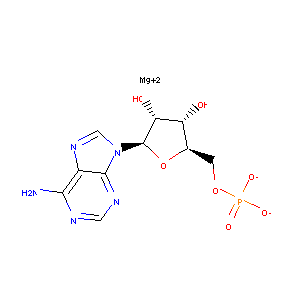

In [3]:
MgAMP_smiles = '[Mg+2].C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H](O3)C\
OP(=O)([O-])[O-])O)O)N'
mol = MolFromSmiles(MgAMP_smiles)
MolToImage(mol)

Brief description of functions availabale in `atom` module:
1. `has_chiral_tag` - returns `1.0` when atom has specified chiral tag,
2. `has_hybridization` - returns `1.0` when atom has specified hybridization,
3. `has_no_symbol` - returns `1.0` when atom has none of the symbols given,
4. `has_symbol` - returns `1.0` when atom has one of the symbols given,
5. `is_aromatic` - returns `1.0` when atom is a part of an aromatic ring,
6. `is_metal` - returns `1.0` when atom is metal,
7. `is_metalloid` - returns `1.0` when atom is metalloid,
8. `is_in_ring` - returns `1.0` when atom is a part of a ring,
9. `get_atom_num` - returns atomic number,
10. `get_charge` - returns formal charge with `shift` value added (set to `0` by default,
11. `get_degree` - returns degree of substitution,
12. `get_group` - returns group number (in periodic table),
13. `get_num_hs` - returns total number of connected hydrogen atoms,
14. `get_period` - returns period number (in periodic table),
15. `get_valence` - returns total valence.

<small>By default, abovementioned functions return `float` values. This can be changed by setting `astype` parameter.  
Functions 9-15 return values divided by `maxval` parameter (set to `1` by default).</small>

In [ ]:
# reference featurizer
data = read_csv('datasets/tox21.csv')
X_raw = DataFrame(data['smiles'])
y_raw = DataFrame(data['NR-AR'])
af = [has_symbol('H'),
      has_symbol('C'),
      has_symbol('O'),
      has_symbol('N'),
      has_no_symbols('HCON'),
      get_num_hs(maxval=8),
      get_degree(maxval=4),
      get_charge(maxval=8),
      get_valence(maxval=8),
      is_in_ring(),
      is_aromatic(),
      lambda mol, index: 0,
      has_chiral_tag('CHI_TETRAHEDRAL_CW'),
      has_chiral_tag('CHI_TETRAHEDRAL_CCW'),
      lambda mol, index: 0,
      has_hybridization('S'),
      has_hybridization('SP'),
      has_hybridization('SP2'),
      has_hybridization('SP3'),
      has_hybridization('SP3D'),
      has_hybridization('SP3D2')]
sf = [is_char(char) for char in '()[].:=#\\/@+-234567<>']
Xpipeline = Pipeline(
    [
     ('rebuild_smiles',
      SmilesRebuilder(columns=['smiles'],
                      kekuleSmiles=False,
                      isomericSmiles=True)),
     ('build_isomer_smiles',
      SmilesRebuilder(columns=['smiles'],
                      kekuleSmiles=True,
                      isomericSmiles=True,
                      save_as=['isomer_smiles'])),
     ('insert_ring_tags',
      RingTagInserter(columns=['isomer_smiles'])),
     ('tokenize_smiles',
      RegexTokenizer(columns=['isomer_smiles'],
                     regex=r'.')),
     ('vectorize_smiles',
      SmilesVectorizer(smiles_column='smiles',
                       tokens_column='isomer_smiles',
                       ignore_regex=r'[a-z]',
                       atom_regex=r'[A-Z]',
                       atom_functions=af,
                       struct_functions=sf,
                       max_len=400,
                       h_vector=True))
    ],
    verbose=True
)
ypipeline = Pipeline(
    [
     ('fill_nans',
      NanFiller()),
     ('convert_to_array',
      ToArrayConverter())
    ],
    verbose=True
)
X = Xpipeline.fit_transform(X_raw)
y = ypipeline.fit_transform(y_raw)